In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#### NLP Libraries ####
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams


stop_words = stopwords.words('english')

In [2]:
df = pd.read_csv('vader_scores_plus_top_words.csv')

In [3]:
df.drop(columns=['Unnamed: 0', 'top_words_VADER'], inplace=True)

In [4]:
df.head(1).T

,0
id,46493
business_id,--OS_I7dnABrXvRCCuWOGQ
name,Lens Auto Body & Painting
address,4819 Cottman Ave
city,Philadelphia
state,PA
postal_code,19135
latitude,40.02816
longtitude,-75.033803
stars,4.0


<Axes: >

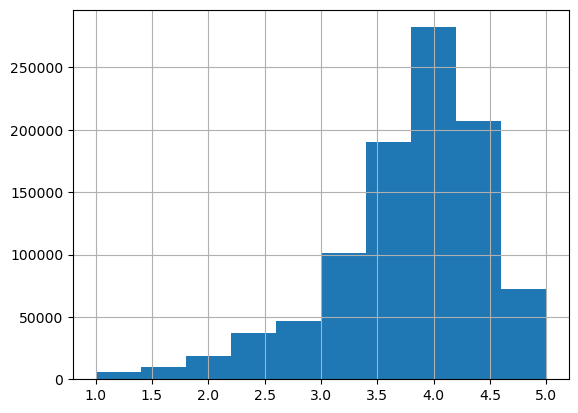

In [5]:
df['avg_stars_per_reviews'].hist()

In [6]:
neg_df_v1 = df[df['avg_stars_per_reviews'] < 3]
pos_df_v1 = df[df['avg_stars_per_reviews'] > 4.5]

neg_df_v1['label'] = np.zeros(neg_df_v1.shape[0])
pos_df_v1['label'] = np.ones(pos_df_v1.shape[0])

df_modeling = pd.concat([pos_df_v1, neg_df_v1], axis=0).reset_index()

/var/folders/hy/m73nj7zd0f746_my9g1b255h0000gn/T/ipykernel_75469/1338559343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df_v1['label'] = np.zeros(neg_df_v1.shape[0])
/var/folders/hy/m73nj7zd0f746_my9g1b255h0000gn/T/ipykernel_75469/1338559343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df_v1['label'] = np.ones(pos_df_v1.shape[0])


In [7]:
# issue we lose lots of data because its exclusive of a large chunk of information 
df_modeling.head(2).T

,0,1
index,1194,1195
id,6790,6790
business_id,-0fvhILrC9UsQ6gLNpZlTQ,-0fvhILrC9UsQ6gLNpZlTQ
name,David's Southern Fried Pies,David's Southern Fried Pies
address,8601 Frankford Ave,8601 Frankford Ave
city,Philadelphia,Philadelphia
state,PA,PA
postal_code,19136,19136
latitude,40.046191,40.046191
longtitude,-75.01509,-75.01509


In [8]:
df['label_stars'] = (df['stars-2'] >= 4.0).astype(int)

In [9]:
df.head(3).T

,0,1,2
id,46493,46493,46493
business_id,--OS_I7dnABrXvRCCuWOGQ,--OS_I7dnABrXvRCCuWOGQ,--OS_I7dnABrXvRCCuWOGQ
name,Lens Auto Body & Painting,Lens Auto Body & Painting,Lens Auto Body & Painting
address,4819 Cottman Ave,4819 Cottman Ave,4819 Cottman Ave
city,Philadelphia,Philadelphia,Philadelphia
state,PA,PA,PA
postal_code,19135,19135,19135
latitude,40.02816,40.02816,40.02816
longtitude,-75.033803,-75.033803,-75.033803
stars,4.0,4.0,4.0


In [10]:
# Sample text
text = "This is a sample bad text for N-gram sentiment analysis."

# Tokenize text into N-grams
n = 3  # Specify the desired N-gram length
tokens = nltk.word_tokenize(text)
n_grams = list(ngrams(tokens, n))

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each N-gram
sentiment_scores = []
for gram in n_grams:
    gram_text = ' '.join(gram)
    score = sia.polarity_scores(gram_text)
    sentiment_scores.append(score['compound'])  # Using compound score for simplicity

# Aggregate sentiment scores (e.g., take the average)
avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)

print("Average sentiment score for N-grams:", avg_sentiment)

Average sentiment score for N-grams: -0.18076666666666666


In [49]:
ngram_df = df[['postal_code', 'name-2','business_id', 'preprocessed_text_v1']].dropna()
ngram_df['tokens'] = ngram_df['preprocessed_text_v1'].apply(lambda x: x.split())

In [50]:
ngram_df['num_tokens'] = ngram_df['tokens'].apply(lambda x: len(x))
ngram_df = ngram_df[ngram_df['num_tokens'] >= 3]

In [51]:
si_vader = SentimentIntensityAnalyzer()

n = 3  # Specify the desired N-gram length
sent_review_scores = []
n_grams_list = []
n_gram_scores_list = []

for index, row in ngram_df.iterrows():
    text = row['preprocessed_text_v1']
    
    # nan reviews, somehow missed in data cleaning? 
#     if isinstance(text, float):
#         continue
    
    tokens = nltk.word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    n_grams_list.append(n_grams)
    
#     # some reviews don't meet criteria for n-gram analysis
#     if len(n_grams) == 0:
#         continue

    # calculate sentiment scores for each n-gram
    n_gram_sentiment_scores = []
    for gram in n_grams:
        gram_text = ' '.join(gram)
        score = si_vader.polarity_scores(gram_text)
        n_gram_sentiment_scores.append(score['compound'])  # Using compound score for simplicity
    
    n_gram_scores_list.append(n_gram_sentiment_scores)
    # Aggregate sentiment scores (e.g., take the average)
    avg_sentiment = sum(n_gram_sentiment_scores) / len(n_gram_sentiment_scores)
    sent_review_scores.append(avg_sentiment)

# Add sentiment scores to DataFrame
ngram_df['avg_sent_across_3gram_VADER'] = sent_review_scores
ngram_df['3grams'] = n_grams_list
ngram_df['3grams_scores_VADER'] = n_gram_scores_list

In [55]:
ngram_df.to_csv('NLP_VADER_sentiment_ngram.csv')

In [56]:
ngram_df.head()

,postal_code,name-2,business_id,preprocessed_text_v1,tokens,num_tokens,avg_sent_across_3gram_VADER,3grams,3grams_scores_VADER
0,19135,services,--OS_I7dnABrXvRCCuWOGQ,recently cadillac repaired lens job turned gre...,"[recently, cadillac, repaired, lens, job, turn...",34,0.208059,"[(recently, cadillac, repaired), (cadillac, re...","[0.0, 0.0, 0.0, 0.0, 0.6249, 0.6249, 0.6249, 0..."
1,19135,services,--OS_I7dnABrXvRCCuWOGQ,lens auto body worst would never bring car bes...,"[lens, auto, body, worst, would, never, bring,...",31,-0.218348,"[(lens, auto, body), (auto, body, worst), (bod...","[0.0, -0.6249, -0.6249, -0.6249, 0.0, 0.0, 0.0..."
2,19135,services,--OS_I7dnABrXvRCCuWOGQ,lens auto body awesome using last yr so hes pr...,"[lens, auto, body, awesome, using, last, yr, s...",41,0.228362,"[(lens, auto, body), (auto, body, awesome), (b...","[0.0, 0.6249, 0.6249, 0.6249, 0.0, 0.0, 0.0, 0..."
3,19135,services,--OS_I7dnABrXvRCCuWOGQ,several transaction autobody shop wonderful fa...,"[several, transaction, autobody, shop, wonderf...",59,0.202225,"[(several, transaction, autobody), (transactio...","[0.0, 0.0, 0.5719, 0.5719, 0.5719, 0.0, 0.6249..."
4,19135,services,--OS_I7dnABrXvRCCuWOGQ,past years taken car van len collision repairs...,"[past, years, taken, car, van, len, collision,...",85,-0.068664,"[(past, years, taken), (years, taken, car), (t...","[0.0, 0.0, 0.0, 0.0, -0.3612, -0.3612, -0.3612..."


In [62]:
expanded_data = []

for i, row in ngram_df.iterrows():
    postal_code = row['postal_code']
    name_2 = row['name-2']
    business_id = row['business_id']
    preprocessed_text_v1 = row['preprocessed_text_v1']
    num_tokens = row['num_tokens']
    avg_sent_across_3gram_VADER = row['avg_sent_across_3gram_VADER']
    ngram_pairs = row['3grams']
    scores = row['3grams_scores_VADER']
    
    for ngram, score in zip(ngram_pairs, scores):
        
        if score != 0.0:
            expanded_data.append({'postal_code': postal_code, 
                                  'category': name_2, 
                                  'business_id': business_id, 
                                  'preprocessed_text_v1': preprocessed_text_v1, 
                                  'num_tokens': num_tokens, 
                                  'avg_sent_across_3gram_VADER': avg_sent_across_3gram_VADER, 
                                  'ngram_pair': ngram, 
                                  'score': score}
                                )
            
expanded_df = pd.DataFrame(expanded_data)

In [64]:
expanded_df.to_csv('NLP_VADER_sentiment_ngrams_nonzero.csv')

In [66]:
expanded_df.columns

Index(['postal_code', 'category', 'business_id', 'preprocessed_text_v1',
       'num_tokens', 'avg_sent_across_3gram_VADER', 'ngram_pair', 'score'],
      dtype='object')

In [68]:
ngrams_top_df = (
    expanded_df
    .groupby(['postal_code', 'category', 'avg_sent_across_3gram_VADER', 'ngram_pair'])
    ['score']
    .sum()
    .reset_index()
    .groupby(['postal_code', 'category', 'avg_sent_across_3gram_VADER'])
    .apply(lambda x: x.nlargest(10, 'score'))
    .reset_index(drop=True)
)

KeyboardInterrupt: 

In [ ]:
ngrams_top_df.shape